In [169]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = "/Volumes/GoogleDrive/Meine Ablage/Dokumente/1 - Schule/1 - ETHZ/9. Semester/Master Thesis/thesis/img"

In [28]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                data[run_type][file_size][run] = json_data
    return data

In [39]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
    return deltas

# S3

In [9]:
S3_BASE_PATH = os.path.join(BASE_PATH, "s3")

## P2P

### Variance

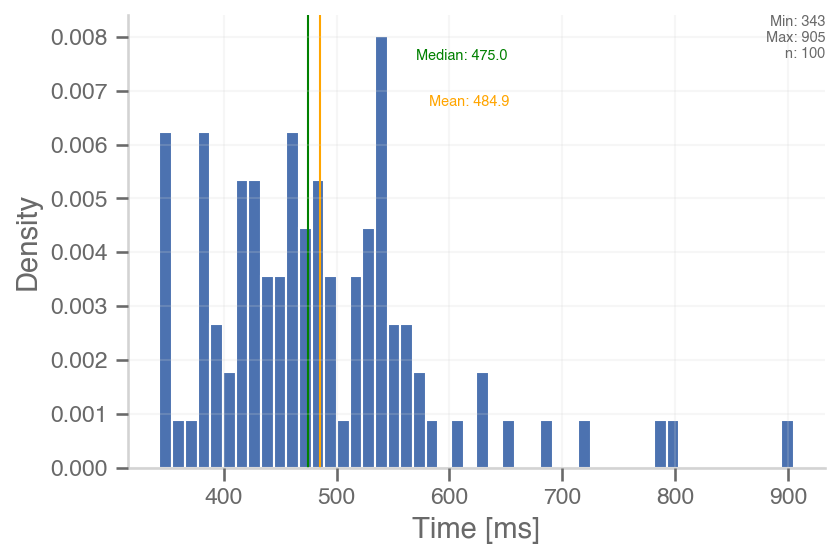

In [170]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "latency_distribution", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
delta_vals = list(deltas[10000000].values())
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50)
plt.xlabel("Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_variance.pdf"))
plt.show()

### Performance

{0.001: 2.4096385542168677e-05, 1.0: 0.022727272727272728, 10.0: 0.19417475728155342, 100.0: 1.492537313432836, 1000.0: 7.662835249042145, 10000.0: 21.34471718249733, 100000.0: 35.637918745545264}


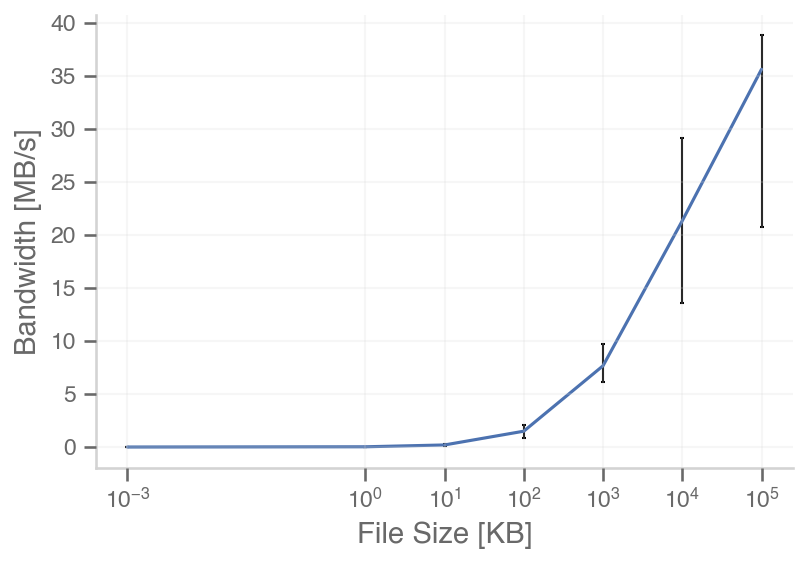

In [175]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "scaling", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = file_size / np.median(values) / 1000
    plot_data[file_size / 1000] = val
    upper_ci = file_size / np.min(values) / 1000 - val
    lower_ci = val - file_size / np.max(values) / 1000
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()))
plt.ylabel("Bandwidth [MB/s]")
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_bandwidth.pdf"))
plt.show()

{0.001: 41.5, 1.0: 44.0, 10.0: 51.5, 100.0: 67.0, 1000.0: 130.5, 10000.0: 468.5, 100000.0: 2806.0}


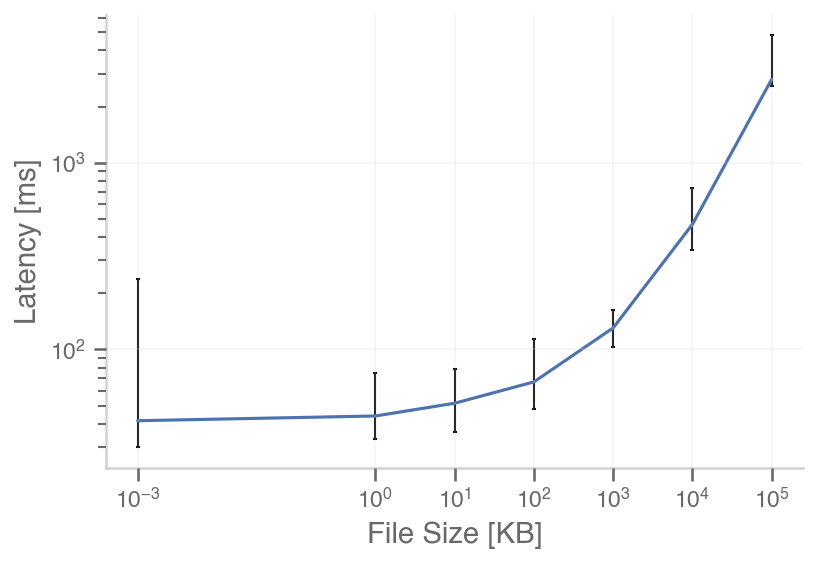

In [176]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "scaling", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = np.median(values)
    plot_data[file_size / 1000] = val
    upper_ci = np.max(values) - val
    lower_ci = val - np.min(values)
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()))
plt.ylabel("Latency [ms]")
plt.yscale('log')
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_latency.pdf"))
plt.show()